# FXA protein
# Data load and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [2]:
%run ./1_Helper_functions.ipynb

In [3]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

## Estimators
### ML Classifiers

In [4]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [5]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 400}
lr = LogisticRegression(**hyparams)

In [6]:
from xgboost import XGBClassifier

hyparams = {'subsample': 0.5, 'n_estimators': 200, 
            'max_depth': 10, 'learning_rate': 0.1,
            'gamma': 1, 'colsample_bytree': 0.5, 
            'alpha': 0.5}

xgb = XGBClassifier(**hyparams)

In [7]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [8]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [9]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [10]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_005 = {'metric_name': 'ef', 
                        
                    'fraction': 0.005, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'}
            )

# Hold-out Validation 

## 30 replicas
### AUC-ROC


In [11]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)

In [12]:
%%time
evaluation_name='ho30'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

metric='roc_auc'
# Normality
display(multi_norm_test(ho30, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric))

File saved: ./cachedir/ho30_fxa


,ml_knn,ml_lr,ml_xgb,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE
Normality,1,1,1,1,1,1,1


,statistic,p
Bartlett,15.143535,0.019169


CPU times: user 1h 9min 51s, sys: 32.9 s, total: 1h 10min 24s
Wall time: 23min 48s


### Statistical Evaluation
#### Multiple classifiers

In [13]:
%run Friedman_and_Nemenyi_test.ipynb

In [14]:
ho30_auc = ho30.loc['roc_auc']

#### Friedman's test

In [15]:
friedmanTest(ho30_auc)

,chi^2,dof,p_value
Friedman Test,174.9,6,4.105525e-35


In [16]:
friedman_imanDavenportTest(ho30_auc)

,F,dof1,dof2,p_value
Friedman Test,994.529412,6,174,8.280613e-132


#### Nemenyi test - pairwise comparison

In [17]:
display(pairwise_nemenyi(ho30_auc)[0].style.applymap(_col_sig_p_values))

,cs_MAX,cs_MEAN,cs_MIN,cs_VOTE,ml_knn,ml_lr,ml_xgb
cs_MAX,1.000000,0.001000,0.473344,0.001000,0.001000,0.001000,0.001000
cs_MEAN,0.001000,1.000000,0.155535,0.900000,0.100830,0.001000,0.001000
cs_MIN,0.473344,0.155535,1.000000,0.134936,0.001000,0.001000,0.001000
cs_VOTE,0.001000,0.900000,0.134936,1.000000,0.117381,0.001000,0.001000
ml_knn,0.001000,0.100830,0.001000,0.117381,1.000000,0.510144,0.004974
ml_lr,0.001000,0.001000,0.001000,0.001000,0.510144,1.000000,0.545281
ml_xgb,0.001000,0.001000,0.001000,0.001000,0.004974,0.545281,1.000000


### Visualizations

#### Swarm plot

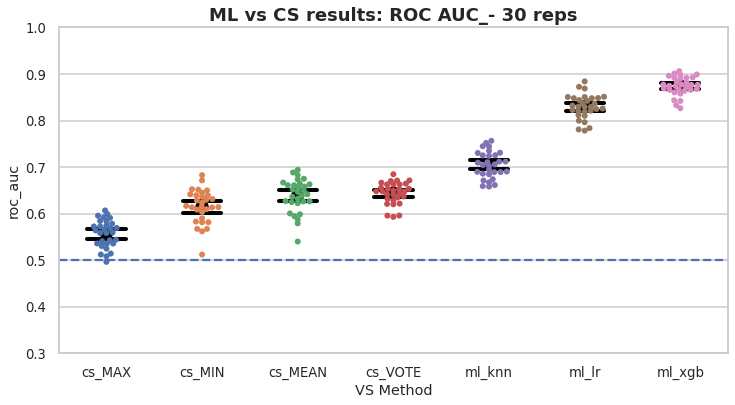

In [18]:
metric='roc_auc'
plot_swarm_metrics(ho30, metric_name=metric, ascending=True, title_extra='- 30 reps')

#### Critical Differences plot

Critical Difference: 3.4044266913143146


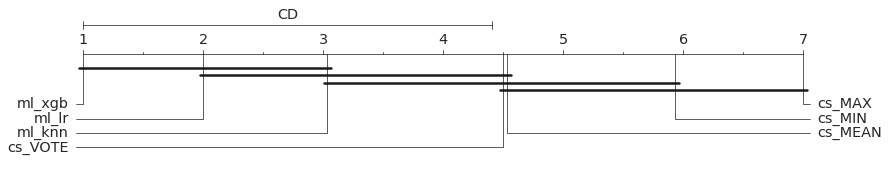

In [19]:
plot_cd(ho30_auc)

#### p-values heatmap

         cs_MAX  cs_MEAN  cs_MIN  cs_VOTE  ml_knn  ml_lr  ml_xgb
cs_MAX     -1.0      1.0     0.0      1.0     1.0    1.0     1.0
cs_MEAN     1.0     -1.0     0.0      0.0     0.0    1.0     1.0
cs_MIN      0.0      0.0    -1.0      0.0     1.0    1.0     1.0
cs_VOTE     1.0      0.0     0.0     -1.0     0.0    1.0     1.0
ml_knn      1.0      0.0     1.0      0.0    -1.0    0.0     2.0
ml_lr       1.0      1.0     1.0      1.0     0.0   -1.0     0.0
ml_xgb      1.0      1.0     1.0      1.0     2.0    0.0    -1.0
-----------


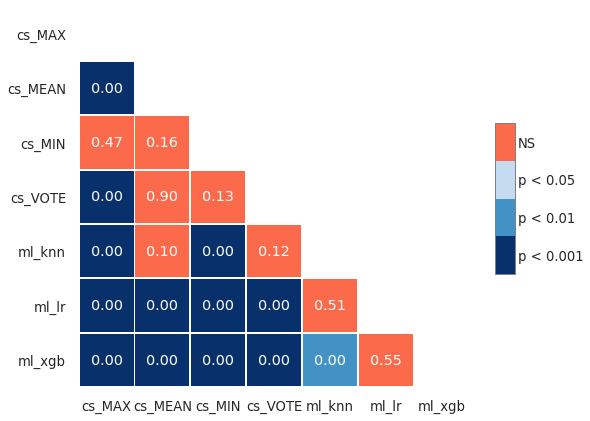

In [20]:
plot_p_heatmap(ho30_auc)

#### Boxplot: Pairwise statistical significance

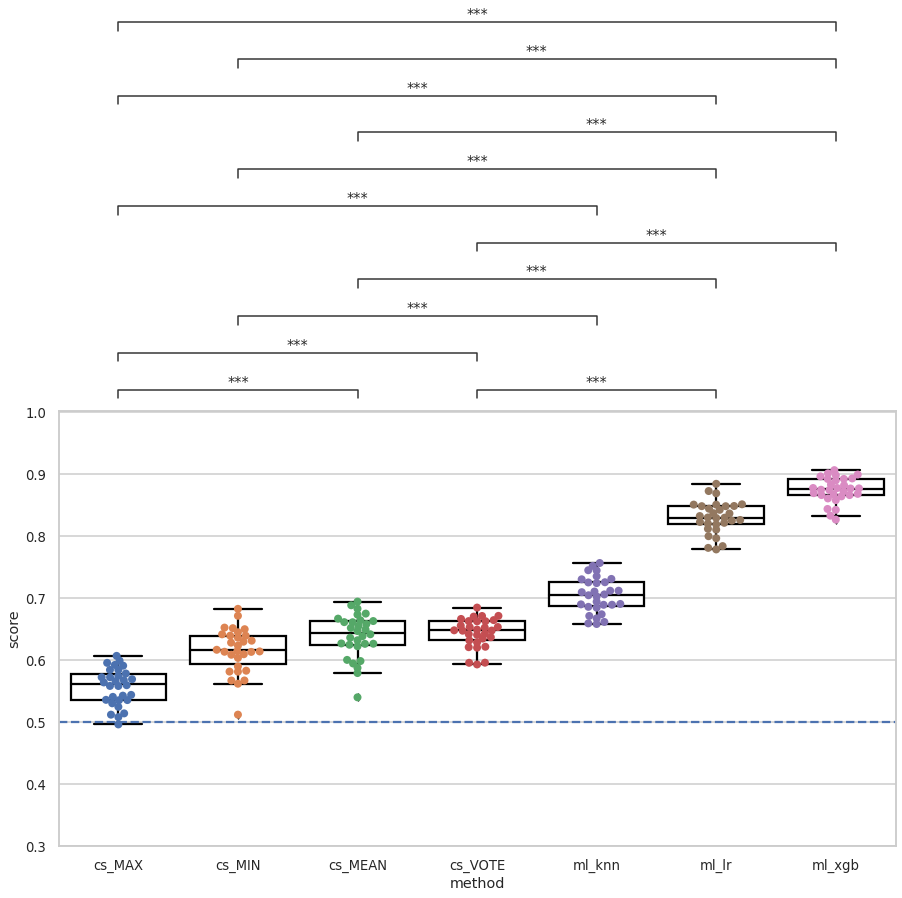

In [21]:
plot_box_signif(ho30, 'roc_auc', ascending=True)

# Y-randomization test

In [22]:
@run_or_load_joblib
def n_hout_val_scrambling(filename, y, random_chi,  **kwargs):
    y_rand = randomize_y_labels(y_target=y, random_chi=random_chi)
    results = n_hold_out_validation(y=y_rand, **kwargs)
    return results

In [26]:
%%time
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
n_reps=30
chi_results = {}
evaluation_name = f'y_scrambling_{n_reps}_reps'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = n_hout_val_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_reps=n_reps, random_state=42)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File saved: ./cachedir/y_scrambling_30_reps_fxa_chi-1
Fraction chi=1 finished.
File saved: ./cachedir/y_scrambling_30_reps_fxa_chi-0.75
Fraction chi=0.75 finished.
File saved: ./cachedir/y_scrambling_30_reps_fxa_chi-0.5
Fraction chi=0.5 finished.
File saved: ./cachedir/y_scrambling_30_reps_fxa_chi-0.25
Fraction chi=0.25 finished.
File saved: ./cachedir/y_scrambling_30_reps_fxa_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 1h 1min 33s, sys: 1min 26s, total: 1h 2min 59s
Wall time: 19min 56s


In [56]:
get_ci = lambda x: st.t.interval(0.95, len(x) - 1,
                loc=np.mean(x), scale=st.sem(x))

get_stats = lambda r: pd.Series(
        {'mean': r.mean(), 
         'std': r.std(),
         'ci_u': get_ci(r)[1],
         'ci_d': get_ci(r)[0]
        }) 

In [57]:
chi_results['chi_1'].loc['roc_auc']\
    .apply(
        get_stats
    )

,ml_knn,ml_lr,ml_xgb,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE
mean,0.497960,0.522000,0.527175,0.480932,0.481977,0.487495,0.499820
std,0.008956,0.027526,0.027076,0.033171,0.031441,0.022088,0.021984
ci_u,0.501304,0.532278,0.537285,0.493318,0.493717,0.495743,0.508029
ci_d,0.494616,0.511722,0.517065,0.468545,0.470237,0.479248,0.491611


/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

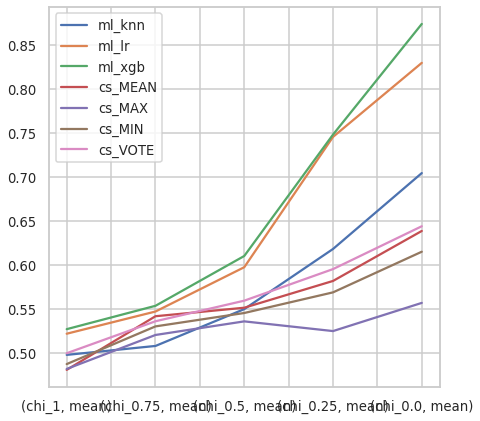

In [74]:
import scipy.stats as st

metric_name = 'roc_auc'
stats_df = []

for chi in chi_results.keys():
    df =  chi_results[chi].loc[metric_name]
    stats = df.apply(get_stats)
    stats_df.append(stats)
    
o = pd.concat(stats_df, keys=chi_results.keys()).loc[(slice(None), 'mean'),:]
# remove the first multiindex
# 
o.plot()

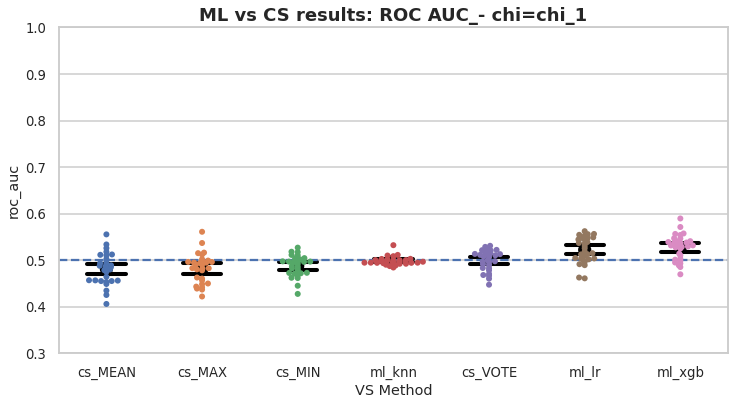

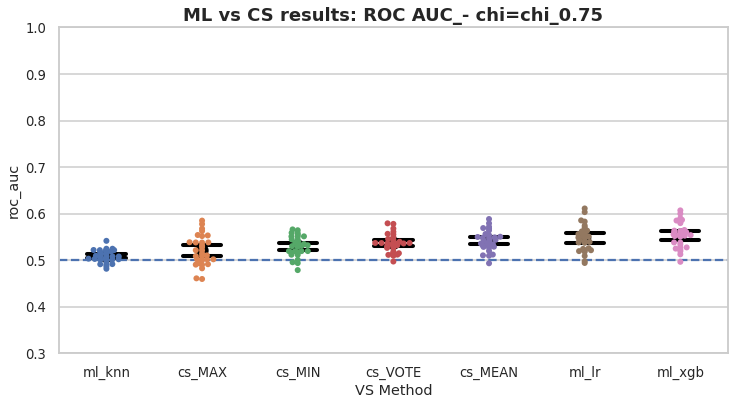

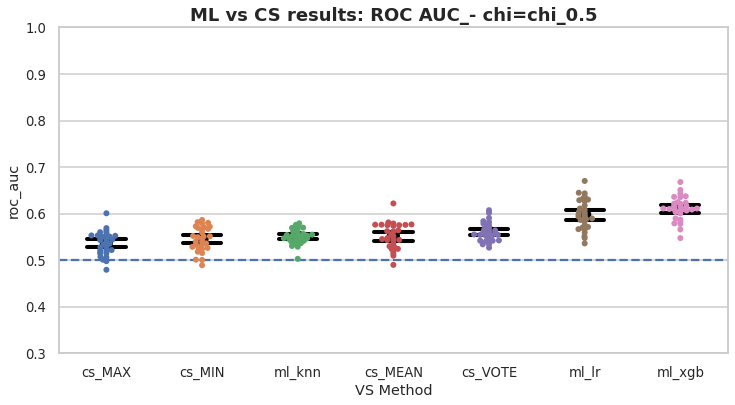

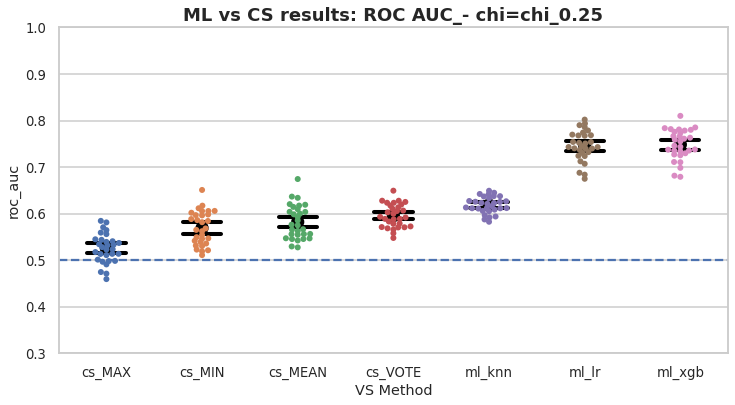

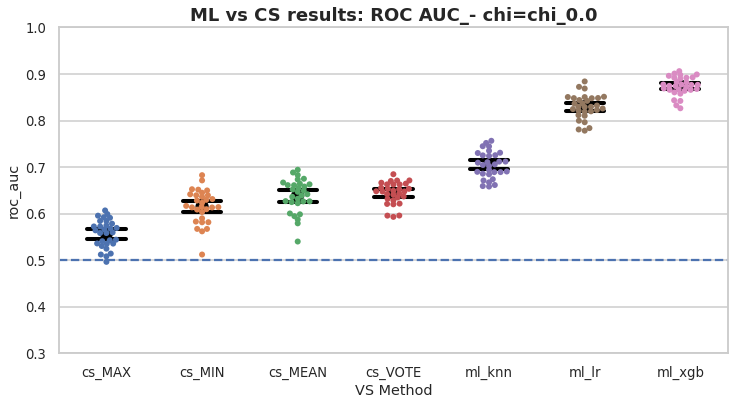

In [27]:
for chi in chi_results.keys():
    a = chi_results[chi]
    plot_swarm_metrics(a, metric_name=metric, ascending=True, title_extra=f'- chi={chi}')

In [79]:

%run ./1_Helper_functions.ipynb

In [76]:
np.random.choice(8, 2)

array([1, 0])

,ml_knn,ml_lr,ml_xgb,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE
Normality,1,1,1,1,1,1,1


CPU times: user 6.15 s, sys: 176 ms, total: 6.33 s
Wall time: 2.7 s


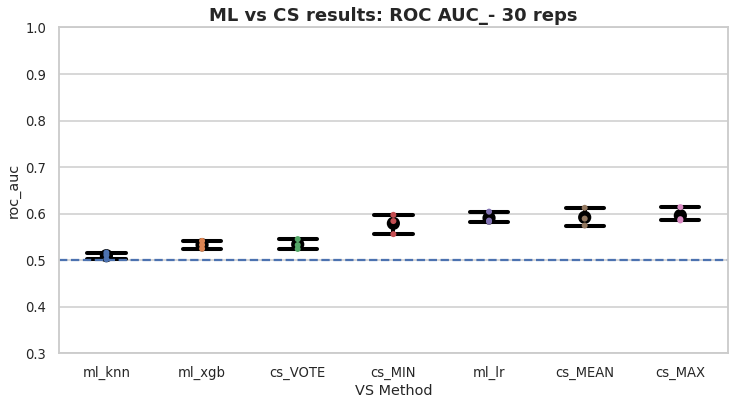

In [81]:
%%time
evaluation_name='test_k_confs'
test_k = n_hold_out_validation(
#     filename=f'./cachedir/{evaluation_name}',
    estimators=estimators, X=X, y=y, 
    metrics=metrics, 
    n_reps=3, random_state=42,
    random_vars=True,
    k_random_vars=2
    )

metric='roc_auc'
# Normality
display(multi_norm_test(test_k, metric=metric))
# Homocedasticity
plot_swarm_metrics(test_k, metric_name=metric, ascending=True, title_extra='- 30 reps')

,ml_knn,ml_lr,ml_xgb,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE
Normality,1,1,1,1,1,1,1


CPU times: user 20 s, sys: 213 ms, total: 20.2 s
Wall time: 8.16 s


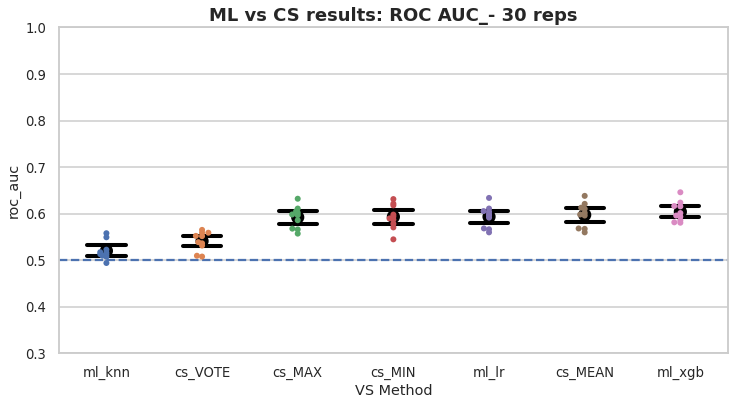

In [82]:
%%time
evaluation_name='test_k_confs'
test_k = n_hold_out_validation(
#     filename=f'./cachedir/{evaluation_name}',
    estimators=estimators, X=X, y=y, 
    metrics=metrics, 
    n_reps=10, random_state=42,
    random_vars=True,
    k_random_vars=2
    )

metric='roc_auc'
# Normality
display(multi_norm_test(test_k, metric=metric))
# Homocedasticity
plot_swarm_metrics(test_k, metric_name=metric, ascending=True, title_extra='- 30 reps')

,ml_knn,ml_lr,ml_xgb,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE
Normality,1,1,1,1,1,1,1


CPU times: user 2min 54s, sys: 5.08 s, total: 2min 59s
Wall time: 58.4 s


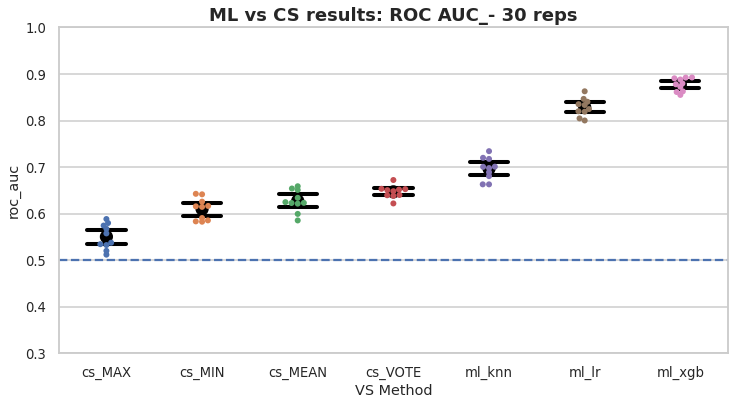

In [83]:
%%time
evaluation_name='test_k_confs'
test_k = n_hold_out_validation(
#     filename=f'./cachedir/{evaluation_name}',
    estimators=estimators, X=X, y=y, 
    metrics=metrics, 
    n_reps=10, random_state=42,
    random_vars=True,
    k_random_vars=100
    )

metric='roc_auc'
# Normality
display(multi_norm_test(test_k, metric=metric))
# Homocedasticity
plot_swarm_metrics(test_k, metric_name=metric, ascending=True, title_extra='- 30 reps')